# Libraries

In [ ]:
!pip install tensorflow
!pip install tensorflow-addons
!pip install matplotlib
!pip install opencv-python
!pip install numpy

Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/rich/color_triplet.py", line 4, in <module>
    class ColorTriplet(NamedTuple):
  File "/usr/lib/python3.10/typing.py", line 2279, in __new__
    nm_tpl = _make_nmtuple(typename, types.items(),
  File "/usr/lib/python3.10/typing.py", line 2251, in _make_nmtuple
    nm_tpl = collections.namedtuple(name, fields,
  File "/usr/lib/python3.10/collections/__init__.py", line 414, in namedtuple
    __new__ = eval(code, namespace)
  File "<string>", line 1, in <module>
KeyboardInterrupt

During handling of the above exception, another excep

In [ ]:
!pip install -U segmentation-models==1.0.1
!pip install keras-unet-collection

In [ ]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [ ]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.model_selection import train_test_split
from google.colab import drive
import segmentation_models as sm
from concurrent.futures import ThreadPoolExecutor
from keras_unet_collection import models as unet_collection
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

# Seed

In [ ]:
os.environ['PYTHONHASHSEED'] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

# HyperParams


In [ ]:
batch_size = 16
epochs = 100
lr = 0.0001
width = 512
height = 384
backbone = 'efficientnetb4'

# Get Dataset


In [ ]:
from google.colab import userdata
from roboflow import Roboflow
rf = Roboflow(api_key=userdata.get('ROBOFLOW_API_KEY'))
project = rf.workspace("minh-sf1op").project("building-segmentaion")
version = project.version(1)
dataset = version.download("png-mask-semantic")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Building-Segmentaion-1 in png-mask-semantic:: 100%|██████████| 2064/2064 [00:00<00:00, 3473.96it/s]


# Data Prepataion


In [ ]:
!pwd

/content


In [ ]:
%cd /content/Building-Segmentaion-1

/content/Building-Segmentaion-1


In [ ]:
!ls

README.dataset.txt  README.roboflow.txt  test  train  valid


In [ ]:
import tensorflow as tf
import os

def load_image_and_mask(image_path, mask_path, img_size=(256, 256)):
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize

    # Load mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, img_size)
    mask = tf.cast(mask, tf.float32) / 255.0  # Normalize to 0 or 1

    return image, mask

def take_path(folder_path):
    image_paths = []
    mask_paths = []

    # Get the list of files in the directory
    files = os.listdir(folder_path)

    # Iterate through the files by index
    for image in os.listdir(folder_path):
        if image.endswith(".jpg"):
            image_path = os.path.join(folder_path, image)
            mask_path = os.path.join(folder_path, image.replace(".jpg", "_mask.png"))

            image_paths.append(image_path)
            mask_paths.append(mask_path)


    return image_paths, mask_paths  # Return the lists instead of single paths


## Data Visualization


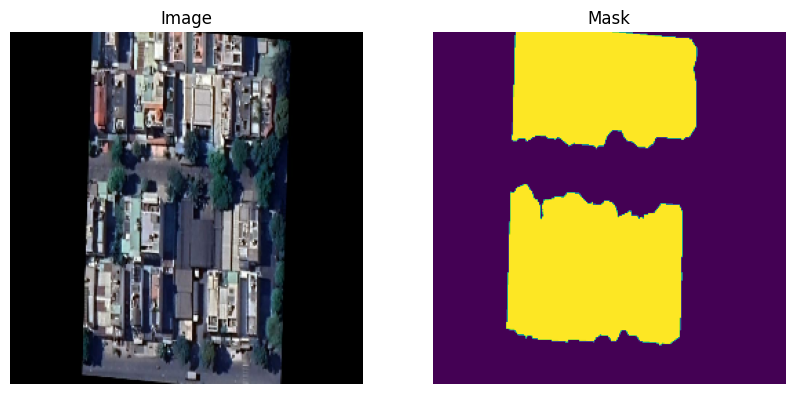

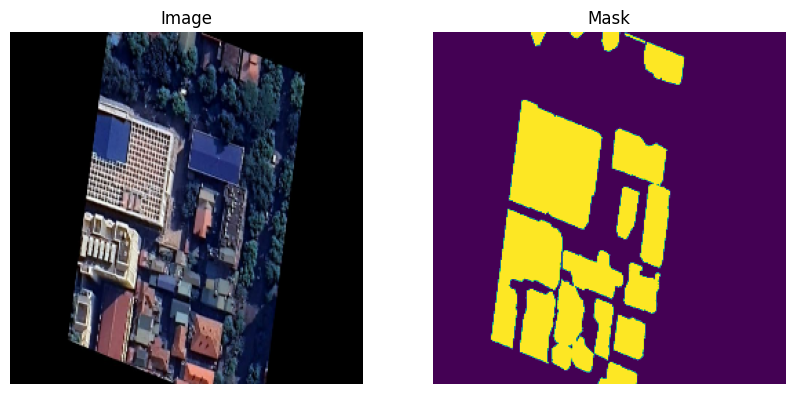

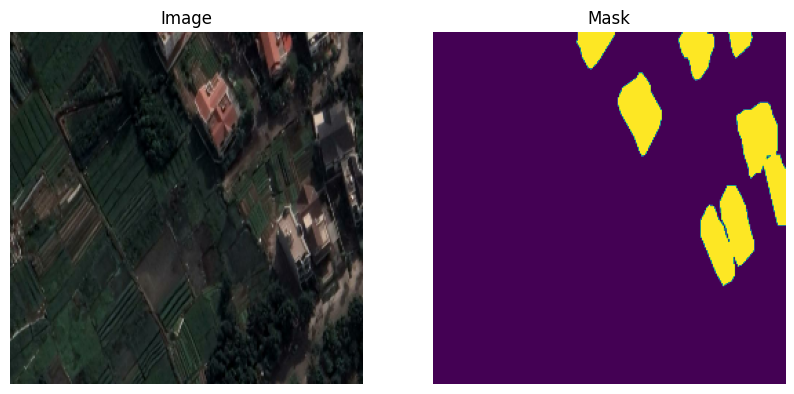

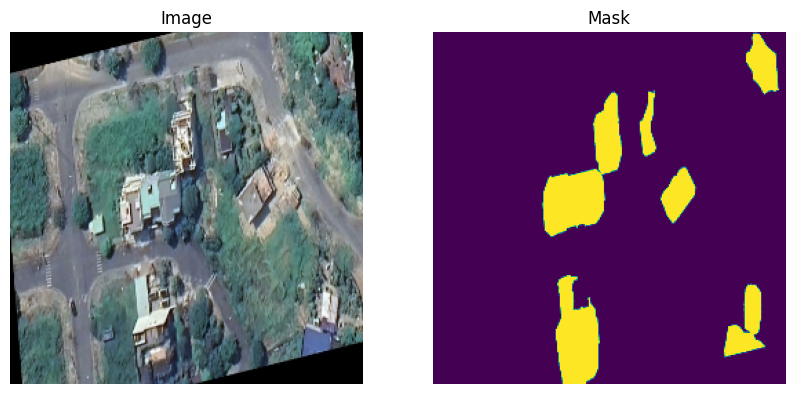

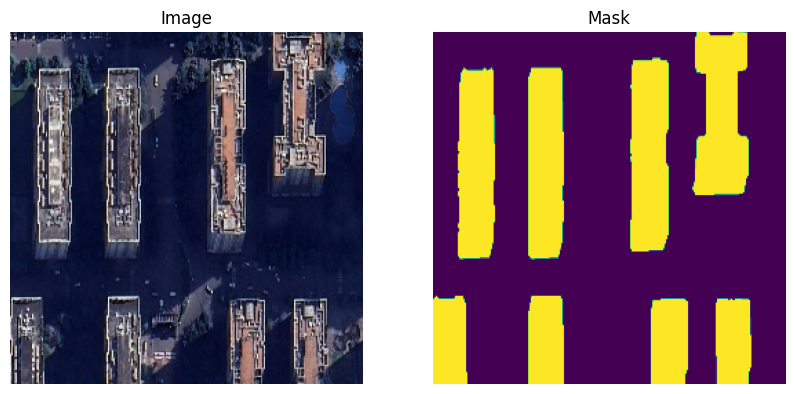

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

folde_path = "train"

image_paths, mask_paths = take_path(folde_path)

for image_path, mask_path in zip(image_paths[:5], mask_paths[:5]):
    image, mask = load_image_and_mask(image_path, mask_path)

    #show several images
    fig, ax = plt.subplots(1, 2, figsize=(10, 8))
    ax[0].imshow((image.numpy()*255).astype("uint8"))
    ax[0].set_title("Image")
    ax[0].axis("off")
    ax[1].imshow(mask.numpy())
    ax[1].set_title("Mask")
    ax[1].axis("off")
    plt.show()

## Create a TensorFlow Dataset

In [ ]:
# Define the paths for the train and validation sets
train_folder_path = 'train'
val_folder_path = 'valid'

# Get image and mask paths for training
train_image_paths, train_mask_paths = take_path(train_folder_path)

# Get image and mask paths for validation
val_image_paths, val_mask_paths = take_path(val_folder_path)

# show the shape of train and valid set
print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of validation images: {len(val_image_paths)}")

# Create TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_mask_paths))

# Map the load_image_and_mask function to each element in the dataset
train_dataset = train_dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch the datasets
train_dataset = train_dataset.batch(16).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

Number of training images: 948
Number of validation images: 40


# Models Make

## Unet 3+

In [ ]:
unet3plus=unet_collection.unet_3plus_2d((height, width, 3), n_labels=1, filter_num_down=[64, 128, 256, 512],
                             filter_num_skip='auto', filter_num_aggregate='auto',
                             stack_num_down=2, stack_num_up=1, activation='ReLU', output_activation='Sigmoid',
                             batch_norm=True, pool='max', unpool=False, deep_supervision=True, name='unet3plus')
unet3plus.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy', sm.metrics.IOUScore(threshold=0.5), sm.metrics.Recall(threshold=0.5), sm.metrics.Precision(threshold=0.5)])
unet3plus.summary()

Automated hyper-parameter determination is applied with the following details:
----------
	Number of convolution filters after each full-scale skip connection: filter_num_skip = [64, 64, 64]
	Number of channels of full-scale aggregated feature maps: filter_num_aggregate = 256
----------
deep_supervision = True
names of output tensors are listed as follows ("sup0" is the shallowest supervision layer;
"final" is the final output layer):

	unet3plus_output_sup0_activation
	unet3plus_output_sup1_activation
	unet3plus_output_sup2_activation
	unet3plus_output_final_activation


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 384, 512, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down0_0         │ (None, 384, 512, 64)   │          1,728 │ input_layer_5[0][0]    │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down0_0_bn      │ (None, 384, 512, 64)   │            256 │ unet3plus_down0_0[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down0_0_activa… │ (None, 384, 512, 64)   │              0 │ unet3plus_down0_0_bn[… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down0_1         │ (None, 384, 512, 64)   │         36,864 │ unet3plus_down0_0_act… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down0_1_bn      │ (None, 384, 512, 64)   │            256 │ unet3plus_down0_1[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down0_1_activa… │ (None, 384, 512, 64)   │              0 │ unet3plus_down0_1_bn[… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down1_encode_m… │ (None, 192, 256, 64)   │              0 │ unet3plus_down0_1_act… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down1_conv_0    │ (None, 192, 256, 128)  │         73,728 │ unet3plus_down1_encod… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down1_conv_0_bn │ (None, 192, 256, 128)  │            512 │ unet3plus_down1_conv_… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down1_conv_0_a… │ (None, 192, 256, 128)  │              0 │ unet3plus_down1_conv_… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down1_conv_1    │ (None, 192, 256, 128)  │        147,456 │ unet3plus_down1_conv_… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down1_conv_1_bn │ (None, 192, 256, 128)  │            512 │ unet3plus_down1_conv_… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 7,880,290 (30.06 MB)

 Trainable params: 7,872,994 (30.03 MB)

 Non-trainable params: 7,296 (28.50 KB)

## Unet EffnetB7

In [ ]:
Unet_EffnetB7=sm.Unet(backbone_name=backbone, encoder_weights='imagenet', classes=1, activation='sigmoid', input_shape=(height, width, 3))
Unet_EffnetB7.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
Unet_EffnetB7.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 384, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 192, 256, 48)   │          1,296 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 192, 256, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 192, 256, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 192, 256, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 192, 256, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 192, 256, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 48)       │            624 │ block1a_se_reduce[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_excite         │ (None, 192, 256, 48)   │              0 │ block1a_activation[0]… │
│ (Multiply)                │                        │                │ block1a_se_expand[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 192, 256, 24)   │          1,152 │ block1a_se_excite[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 192, 256, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization) 

 Total params: 25,735,017 (98.17 MB)

 Trainable params: 25,607,833 (97.69 MB)

 Non-trainable params: 127,184 (496.81 KB)

## Linknet EffnetB7

In [ ]:
Linknet_EffnetB7=sm.Linknet(backbone_name=backbone, encoder_weights='imagenet', classes=1, activation='sigmoid', input_shape=(height, width, 3))
Linknet_EffnetB7.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
Linknet_EffnetB7.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 384, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 192, 256, 48)   │          1,296 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 192, 256, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 192, 256, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 192, 256, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 192, 256, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 192, 256, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 48)       │            624 │ block1a_se_reduce[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_excite         │ (None, 192, 256, 48)   │              0 │ block1a_activation[0]… │
│ (Multiply)                │                        │                │ block1a_se_expand[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 192, 256, 24)   │          1,152 │ block1a_se_excite[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 192, 256, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization) 

 Total params: 21,718,217 (82.85 MB)

 Trainable params: 21,586,297 (82.35 MB)

 Non-trainable params: 131,920 (515.31 KB)

## Check points & Logs


In [ ]:
checkpoint_path = '/content/drive/MyDrive/DAP391_G7_Semantic Classification for Urban Planning Assessment/Data/Checkpoints'
os.makedirs(checkpoint_path, exist_ok=True)
checkpoint_unet3p_path = os.path.join(checkpoint_path, 'unet3p.keras')
checkpoint_unet_path = os.path.join(checkpoint_path, 'unet_effnetb7.keras')
checkpoint_linknet_path = os.path.join(checkpoint_path, 'linknet_effnetb7.keras')

# Define the checkpoint callback
checkpoint_unet3p = ModelCheckpoint(
    checkpoint_unet3p_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_freq='epoch'
)

checkpoint_unet_path = ModelCheckpoint(
    checkpoint_unet_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_freq='epoch'
)

checkpoint_linknet_path = ModelCheckpoint(
    checkpoint_linknet_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_freq='epoch'
)

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    mode='min'
)

# Define the CSVLogger callback
csv_logger_unet3p = CSVLogger(
    '/content/drive/MyDrive/DAP391_G7_Semantic Classification for Urban Planning Assessment/Data/CSVLogger_unet3p.csv',
    append=True
)

csv_logger_unet_path = CSVLogger(
    '/content/drive/MyDrive/DAP391_G7_Semantic Classification for Urban Planning Assessment/Data/CSVLogger_unet_path.csv',
    append=True
)

csv_logger_linknet_path = CSVLogger(
    '/content/drive/MyDrive/DAP391_G7_Semantic Classification for Urban Planning Assessment/Data/CSVLogger_linknet_path.csv',
    append=True
)

callbacks = [early_stopping, reduce_lr]


# Model Train

In [ ]:
Unet3p_his = unet3plus.fit(train_dataset,
    validation_data=val_dataset, epochs=epochs, callbacks=[callbacks, checkpoint_unet3p, csv_logger_unet3p])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'gamma', 'beta', 'gamma', 'beta', 'kernel', 'kernel', 'kernel', 'gamma', 'beta', 'gamma', 'beta', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


110/116 ━━━━━━━━━━━━━━━━━━━━ 4s 818ms/step - loss: 0.5754 - unet3plus_output_sup0_activation_accuracy: 0.6601

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


116/116 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - loss: 0.5740 - unet3plus_output_sup0_activation_accuracy: 0.6610 - val_loss: 0.6166 - val_unet3plus_output_sup0_activation_accuracy: 0.6423 - learning_rate: 1.0000e-04
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,unet3plus_output_sup0_activation_accuracy,val_loss,val_unet3plus_output_sup0_activation_accuracy
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 29s 253ms/step - loss: 0.5152 - unet3plus_output_sup0_activation_accuracy: 0.6915 - val_loss: 0.6445 - val_unet3plus_output_sup0_activation_accuracy: 0.6423 - learning_rate: 1.0000e-04
Epoch 3/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 29s 253ms/step - loss: 0.4867 - unet3plus_output_sup0_activation_accuracy: 0.6988 - val_loss: 0.6943 - val_unet3plus_output_sup0_activation_accuracy: 0.6423 - learning_rate: 1.0000e-04
Epoch 4/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 29s 253ms/step - loss: 0.4580 - unet3plus_output_sup0_activation_accuracy: 0.7061 - val_loss: 0.6298 - val_unet3plus_output_sup0_activation_accuracy: 0.6397 - learning_rate: 1.0000e-04
Epoch 5/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 29s 253ms/step - loss: 0.4229 - unet3plus_output_sup0_activation_accuracy: 0.7419 - val_loss: 0.5326 - val_unet3plus_output_sup0_activation_accuracy: 0.8291 - learning_rate: 1.0000e-04
Epoch 6/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 29s 253ms/step - loss: 0.3721 - unet3plus_output_sup0_activation_ac

In [ ]:
Unet_EffnetB7_his = Unet_EffnetB7.fit(train_dataset,
    validation_data=val_dataset, epochs=epochs,  callbacks=[callbacks, checkpoint_unet_path, csv_logger_unet_path])

Epoch 1/100
110/116 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7877 - loss: 0.4993   

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.90238, saving model to /content/drive/MyDrive/DAP391_G7_Semantic Classification for Urban Planning Assessment/Data/Checkpoints/unet_effnetb7.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.7916 - loss: 0.4935 - val_accuracy: 0.9024 - val_loss: 0.4284 - learning_rate: 1.0000e-04
Epoch 2/100
110/116 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.9281 - loss: 0.2418
Epoch 2: val_accuracy improved from 0.90238 to 0.92354, saving model to /content/drive/MyDrive/DAP391_G7_Semantic Classification for Urban Planning Assessment/Data/Checkpoints/unet_effnetb7.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 26s 221ms/step - accuracy: 0.9283 - loss: 0.2409 - val_accuracy: 0.9235 - val_loss: 0.2552 - learning_rate: 1.0000e-04
Epoch 3/100
110/116 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.9435 - loss: 0.1806
Epoch 3: val_accuracy improved from 0.92354 to 0.93976, saving model to /content/drive/MyDrive/DAP391_G7_Semantic Classification for Urban

In [ ]:
Linknet_EffnetB7_his = Linknet_EffnetB7.fit(train_dataset,
    validation_data=val_dataset, epochs=epochs, callbacks=[callbacks, checkpoint_linknet_path, csv_logger_linknet_path])

Epoch 1/100
110/116 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6455 - loss: 0.6371   

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.85202, saving model to /content/drive/MyDrive/DAP391_G7_Semantic Classification for Urban Planning Assessment/Data/Checkpoints/linknet_effnetb7.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.6516 - loss: 0.6307 - val_accuracy: 0.8520 - val_loss: 0.4451 - learning_rate: 1.0000e-04
Epoch 2/100
110/116 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.9129 - loss: 0.3023
Epoch 2: val_accuracy improved from 0.85202 to 0.91067, saving model to /content/drive/MyDrive/DAP391_G7_Semantic Classification for Urban Planning Assessment/Data/Checkpoints/linknet_effnetb7.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 25s 219ms/step - accuracy: 0.9132 - loss: 0.3012 - val_accuracy: 0.9107 - val_loss: 0.3336 - learning_rate: 1.0000e-04
Epoch 3/100
110/116 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.9325 - loss: 0.2277
Epoch 3: val_accuracy improved from 0.91067 to 0.92752, saving model to /content/drive/MyDrive/DAP391_G7_Semantic Classification for

# Model Eval

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pwd
%cd ..

/content/Building-Segmentaion-1
/content


In [ ]:
%cd /content/drive/MyDrive/DAP391_G7_Semantic Classification for Urban Planning Assessment/Data


/content/drive/.shortcut-targets-by-id/1VtZtk2YXh72cia1zIH3h45I4TLZoOuX4/DAP391_G7_Semantic Classification for Urban Planning Assessment/Data


In [ ]:
!ls

 Checkpoints		      CSVLogger_unet3p.csv      Data_New.zip	 NewVal.zip
 CSVLogger.csv		      CSVLogger_unet_path.csv   Final		 Tensorboard
 CSVLogger_linknet_path.csv   Data_New		       'Labelled Data'


In [ ]:
import pandas as pd

df_unet3p = pd.read_csv('CSVLogger_unet3p.csv')
df_unet_EffB7 = pd.read_csv('CSVLogger_unet_path.csv')
df_linknet_EffB7 = pd.read_csv('CSVLogger_linknet_path.csv')

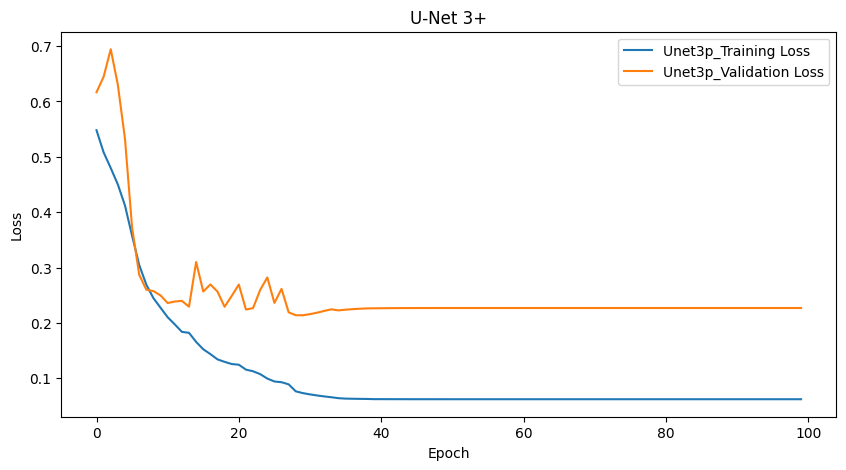

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df_unet3p['loss'], label='Unet3p_Training Loss')
plt.plot(df_unet3p['val_loss'], label='Unet3p_Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('U-Net 3+')
plt.legend()
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

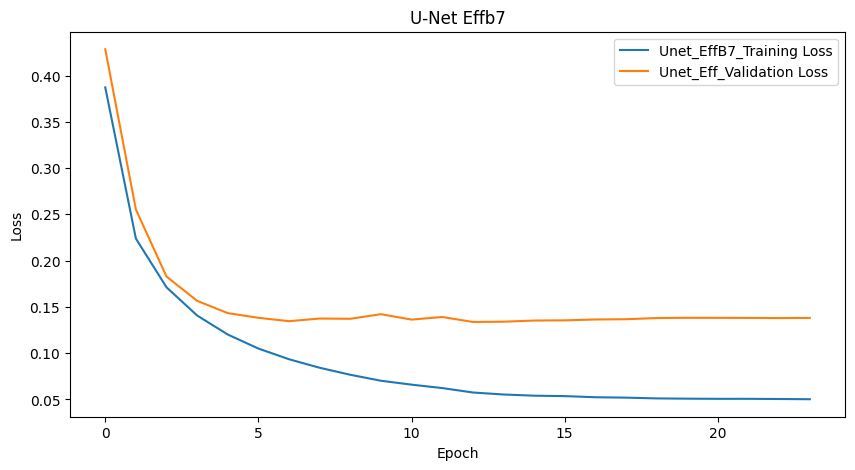

In [ ]:
# unet Effb7
plt.figure(figsize=(10, 5))
plt.plot(df_unet_EffB7['loss'], label='Unet_EffB7_Training Loss')
plt.plot(df_unet_EffB7['val_loss'], label='Unet_Eff_Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('U-Net Effb7')
plt.legend()
plt

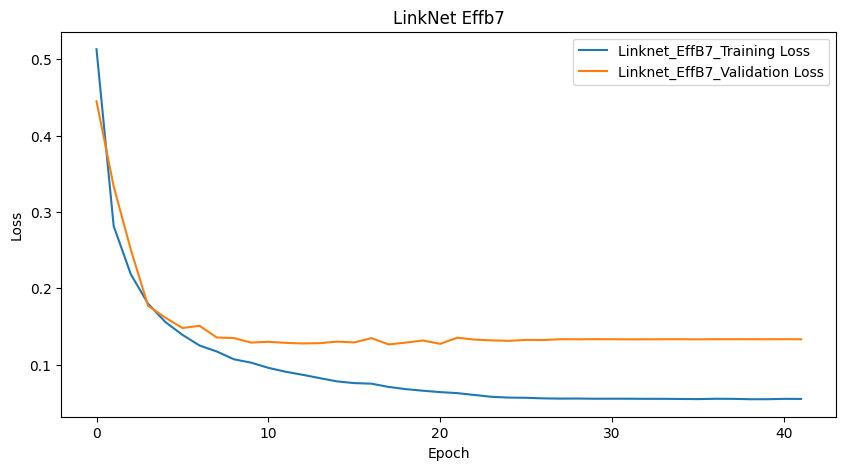

In [ ]:
# link net
plt.figure(figsize=(10, 5))
plt.plot(df_linknet_EffB7['loss'], label='Linknet_EffB7_Training Loss')
plt.plot(df_linknet_EffB7['val_loss'], label='Linknet_EffB7_Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LinkNet Effb7')
plt.legend()